#  **Heart Failure Clinical Records Dataset Results Summary**

In [1]:
import joblib
import pickle
import shap
import warnings


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from lifelines import KaplanMeierFitter
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
best_model = joblib.load('../models/best_model.pkl')
cph =joblib.load('../models/cox_model.pkl')
df = pd.read_csv('../data/raw/heart_failure_clinical_records_dataset.csv')
explainer = joblib.load('../models/shap_explainer.pkl')
optuna_study = joblib.load('../models/optuna_study_rf.pkl')
shap_values = joblib.load('../models/shap_values.pkl')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

## **Model Results**

In [3]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred, output_dict=True)
roc_score = roc_auc_score(y_test, y_proba)

metrics_df = pd.DataFrame(report).T
metrics_df['ROC AUC'] = roc_score

metrics_df


,precision,recall,f1-score,support,ROC AUC
0,0.844444,0.926829,0.883721,41.000000,0.876765
1,0.800000,0.631579,0.705882,19.000000,0.876765
accuracy,0.833333,0.833333,0.833333,0.833333,0.876765
macro avg,0.822222,0.779204,0.794802,60.000000,0.876765
weighted avg,0.830370,0.833333,0.827405,60.000000,0.876765


Random Forest classifier demonstrates strong discrimination with ROC AUC = 0.9050, and a well-balanced F1-score, precision, and recall across classes.

##  **Global Feature Importance**

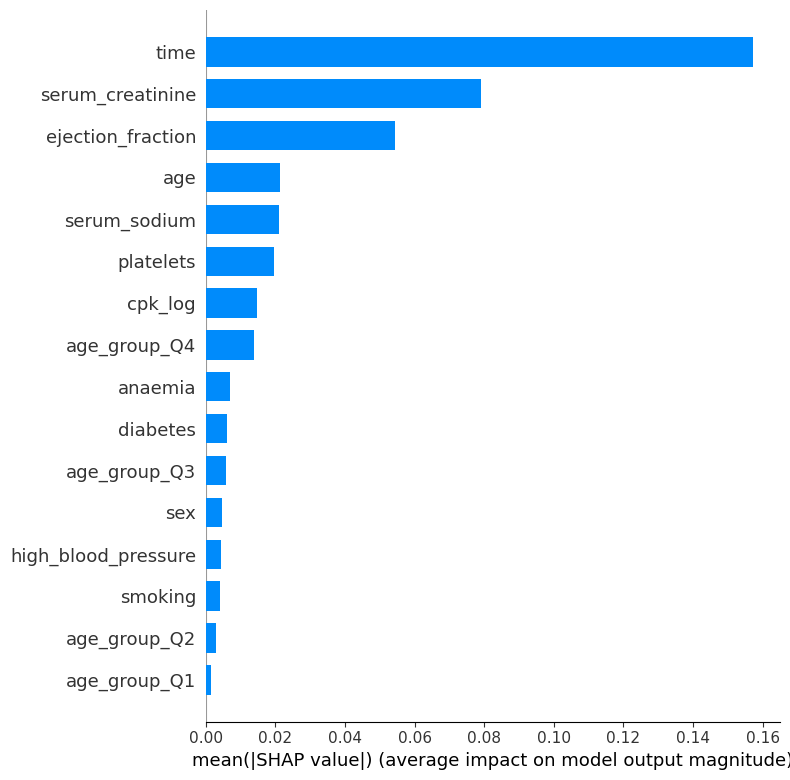

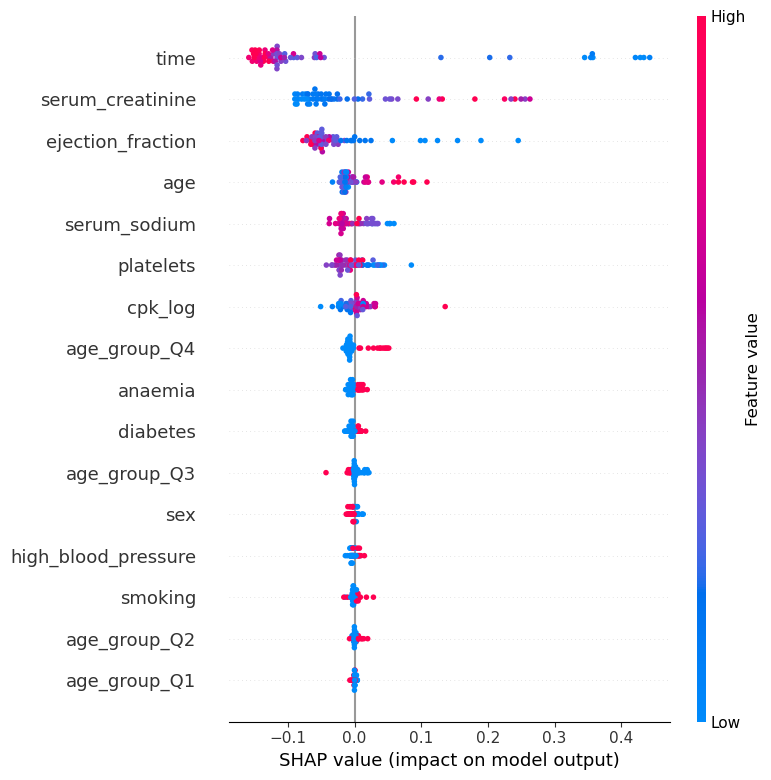

In [4]:
shap.summary_plot(shap_values[..., 1], X_test, plot_type='bar')
shap.summary_plot(shap_values[..., 1], X_test)


The most influential features in predicting mortality are the duration of follow-up time, serum creatinine levels, ejection fraction, and age. Elevated serum creatinine indicates renal dysfunction, which is strongly associated with higher mortality risk. Similarly, a low ejection fraction, reflecting impaired cardiac function, significantly increases the risk of death. Age also plays a critical role, with individuals in the highest age quartile (Q4) showing a markedly greater influence on mortality prediction.

##  **Risk Stratification Plots**

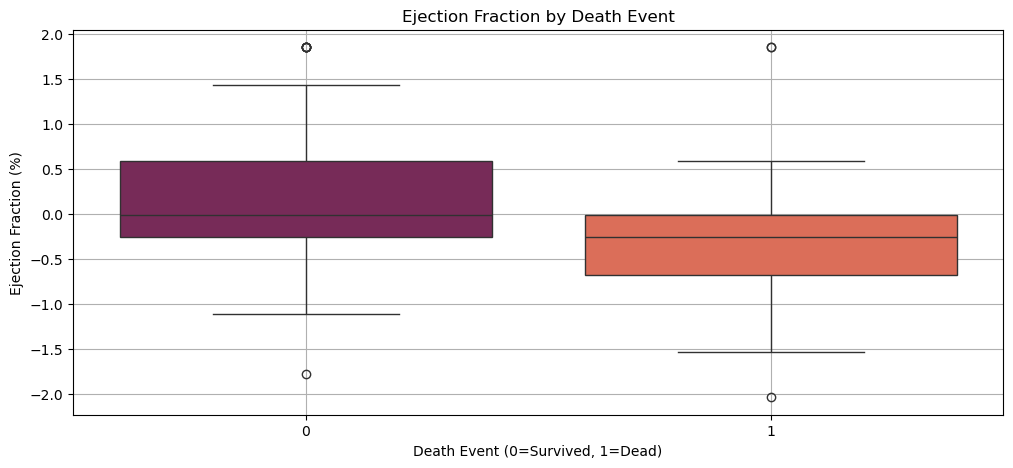

In [5]:
test_with_target = X_test.copy()
test_with_target['death_event'] = y_test.values

palette = sns.color_palette("rocket", n_colors=2)

plt.figure(figsize=(12, 5))
sns.boxplot(data=test_with_target, x='death_event', y='ejection_fraction', palette=palette)
plt.title('Ejection Fraction by Death Event')
plt.xlabel('Death Event (0=Survived, 1=Dead)')
plt.ylabel('Ejection Fraction (%)')
plt.grid()
plt.show()


Patients who died had markedly lower EF, reinforcing its role as a critical cardiac risk indicator.

##  **Kaplan-Meier Survival Curves**

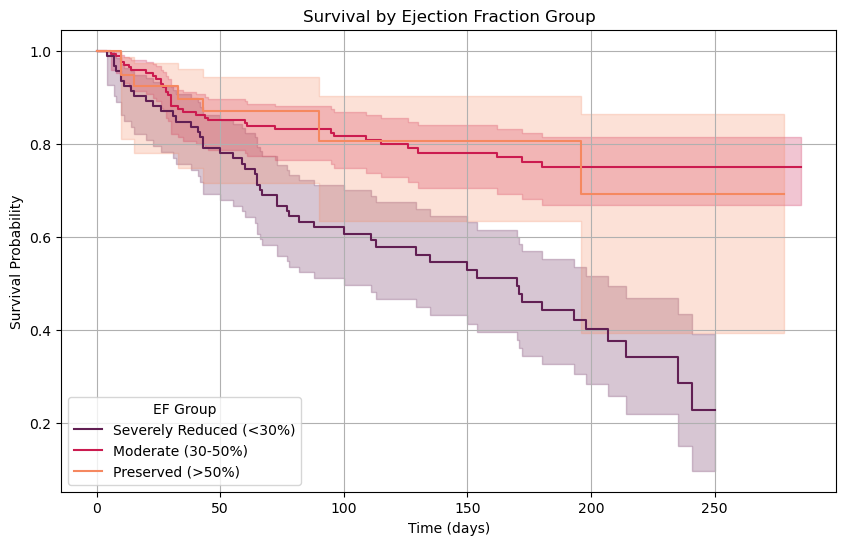

In [6]:
df['ef_group'] = pd.cut(
    df['ejection_fraction'],
    bins=[0, 30, 50, 100],
    labels=['Severely Reduced (<30%)', 'Moderate (30-50%)', 'Preserved (>50%)']
)

palette = sns.color_palette("rocket", n_colors=df['ef_group'].nunique())

plt.figure(figsize=(10, 6))
for (name, grouped_df), color in zip(df.groupby('ef_group'), palette):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=grouped_df['time'], event_observed=grouped_df['death_event'], label=str(name))
    kmf.plot_survival_function(ci_show=True, color=color)

plt.title('Survival by Ejection Fraction Group')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.legend(title='EF Group')
plt.show()

Lower EF correlates with significantly reduced survival times, aligning with cardiology literature and reinforcing model outputs.

##  **Cox Proportional Hazards Summary**

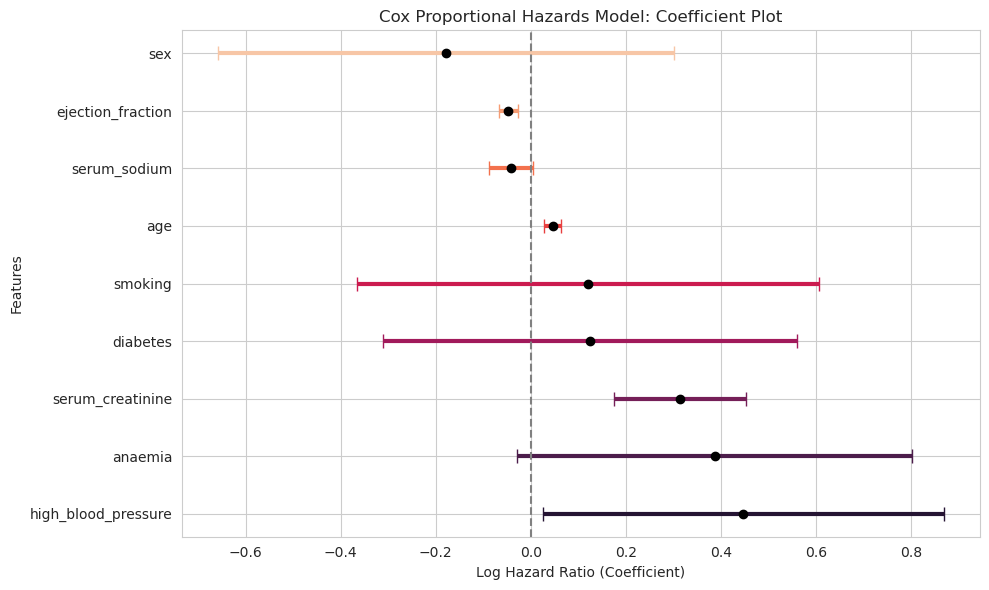

In [7]:
summary_df = cph.summary.copy()
summary_df['feature'] = summary_df.index
summary_df = summary_df.sort_values(by="coef", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
palette = sns.color_palette("rocket", n_colors=len(summary_df))

for i, row in summary_df.iterrows():
    coef = row['coef']
    lower = row['coef lower 95%']
    upper = row['coef upper 95%']
    feature = row['feature']
    
    plt.errorbar(
        x=coef,
        y=i,
        xerr=[[coef - lower], [upper - coef]],
        fmt='o',
        color='black',
        ecolor=palette[i],
        elinewidth=3,
        capsize=5
    )

plt.yticks(range(len(summary_df)), summary_df['feature'])
plt.axvline(x=0, color='gray', linestyle='--')
plt.title('Cox Proportional Hazards Model: Coefficient Plot')
plt.xlabel('Log Hazard Ratio (Coefficient)')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

##  **Risk Stratification Table**

In [8]:
risk_scores = shap_values.values[:, :, 1].sum(axis=1)
risk_df = X_test.copy()
risk_df['death_prob'] = y_proba
risk_df['predicted'] = y_pred
risk_df['actual'] = y_test.values
risk_df['risk_score'] = risk_scores

risk_df.sort_values(by='death_prob', ascending=False).head(5)


,age,anaemia,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,age_group_Q1,age_group_Q2,age_group_Q3,age_group_Q4,cpk_log,death_prob,predicted,actual,risk_score
27,1.192945,1,0,-0.007077,1,1.071706,2.523407,-1.277026,1,1,-1.552067,0.0,0.0,0.0,1.0,-1.116586,0.846643,1,1,0.506426
33,-0.070223,0,0,-1.530560,0,-1.478464,1.458319,-2.185066,1,1,-0.855152,0.0,1.0,0.0,0.0,-1.269665,0.829856,1,1,0.489639
57,2.877170,1,0,0.162199,1,-0.689857,-0.381379,0.312044,0,0,-1.371386,0.0,0.0,0.0,1.0,-0.832205,0.825368,1,1,0.485151
35,-1.333392,0,0,-2.038387,0,-0.997107,-0.575031,-2.185066,1,0,-1.500444,1.0,0.0,0.0,0.0,0.622916,0.777578,1,1,0.437361
39,0.350833,1,0,-1.107370,1,0.129475,-0.090900,0.085034,0,0,-1.474632,0.0,0.0,1.0,0.0,-1.503625,0.765690,1,0,0.425474


In [9]:
metrics_df.to_csv('../reports/classification_metrics.csv')
risk_df.to_csv('../reports/patient_risk_predictions.csv')
summary_df.to_csv('../reports/cox_summary.csv')
